<a href="https://colab.research.google.com/github/mmokhinaa/meowhomework/blob/main/%D0%BC%D0%BE%D1%85%D0%B8%D0%B0%D0%BD_206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключите нужные библиотеки и убедитесь в правильности выбранного устройства. Для начала советую писать на cpu, а на видеокарту переключаться, когда большая часть кода будет готова, чтобы не расходовать лишний ресурс. Чтобы подключить видеокарту, необходимо в настройках сменить среду выполнения на T4GPU. Если видеокарта подключилась успешно, блок кода ниже напечатает cuda.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Для начала разберемся с данными. Мы будем использовать датасет mnist, картинки рукописных надписей десятичных цифр.

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:03<00:00, 3.05MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.13MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch.shape, y_batch.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


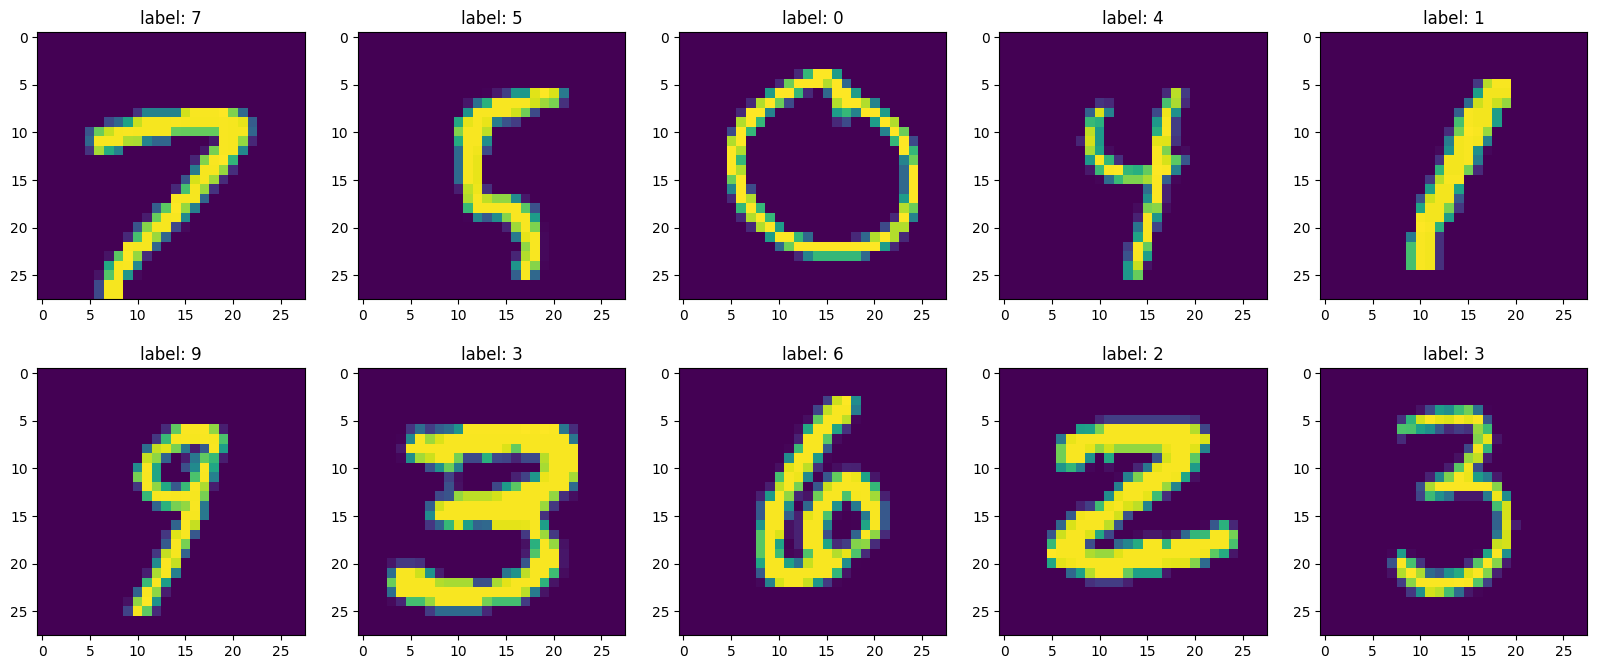

In [5]:
indexes = np.random.randint(X_batch.shape[0], size = 10)
plt.figure(figsize=(20, 8))
for i, index in enumerate(indexes):
  x = plt.subplot(2, 5, i+1)
  x.title.set_text(f"label: {y_batch[index]}")
  plt.imshow(X_batch[index][0])
plt.show()

Как видно с печатей, mnist состоит из одноканальных изображений 28x28 пикселей. Ваша задача - научить свои модели определять цифру на картинке.

Для начала реализуем класс линейной регрессии, используя возможности PyTorch. Дополните код ниже до корректной работы.

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_weights = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x = x + self.bias_weights
        return x

На практике, вместо своего класса можно использовать nn.Linear, обладающий такой же сигнатурой.

In [7]:
linear_model = nn.Sequential(
    nn.Flatten(),
    LinearRegression(28 ** 2, 10) # классификация на 10 классов, значит и выходов столько же
).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(linear_model.parameters())

criterion = nn.CrossEntropyLoss()

Sequential последовательно применит свои аргументы к пропускаемым через него аргументам, его удобно использовать для создания простых моделей или блоков внутри сложных. В качестве функции потерь берем стандартную для классификаторов кросс-энтропию. В качестве метрики будем использовать обычную accuracy, ее легко реализовать руками.

In [8]:
def learning_loop(tr_loader, val_loader, model, loss_fn, optim, epochs=20):
    tr_history = []
    val_history = []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(tr_loader, model, loss_fn, optim)
        val_loss, val_acc = eval_epoch(val_loader, model, loss_fn)

        tr_history.append((tr_loss, tr_acc))
        val_history.append((val_loss, val_acc))

        print(f"epoch: {epoch + 1}; losses: {tr_loss}, {val_loss}; accuracy: {tr_acc}, {val_acc}")

    return tr_history, val_history



In [9]:
def train_epoch(data_loader, model, loss_fn, optim):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) # перебрасываем входные данные на gpu
        optim.zero_grad() # обнуляем градиенты

        logits = model(x_batch.view(-1, 784))
        loss = loss_fn(logits, y_batch) # в данном случае лосс заточен на логиты, и сам применит softmax
        loss.backward() # пробрасываем градиенты
        optim.step() # делаем шаг оптимизатора

        loss_val = loss.item()
        total_loss += loss_val
        preds = logits.argmax(-1)
        correct = preds == y_batch
        correct_predictions += correct.sum().item()
        total_samples += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [10]:
def eval_epoch(data_loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.set_grad_enabled(False): # на валидации модель не должна учиться, градиенты не считаем
            logits = model(x_batch.view(-1, 784)) # оптимизатор в функцию вовсе не передается
            loss = loss_fn(logits, y_batch)
            total_loss += loss.item()
            preds = logits.argmax(-1)
            correct = preds == y_batch
            correct_predictions += correct.sum().item()
            total_samples += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [12]:
epochs = 20
train_history, val_history = learning_loop(
    train_dataloader, valid_dataloader, linear_model, criterion, optimizer, epochs=epochs
)

train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)


epoch: 1; losses: 5.535208483494675, 3.5465684940543354; accuracy: 0.5318333333333334, 0.6556
epoch: 2; losses: 3.014530346464755, 2.38861051994034; accuracy: 0.69585, 0.7451
epoch: 3; losses: 2.229833571196619, 1.881599417027039; accuracy: 0.7596833333333334, 0.7893
epoch: 4; losses: 1.8341687978076529, 1.5980102091650419; accuracy: 0.7943666666666667, 0.8131
epoch: 5; losses: 1.5888524139995006, 1.4141402285121665; accuracy: 0.815, 0.8286
epoch: 6; losses: 1.4202029170639225, 1.2836837303600734; accuracy: 0.8299166666666666, 0.8392
epoch: 7; losses: 1.2967142702292787, 1.1849848438478723; accuracy: 0.8396666666666667, 0.8472
epoch: 8; losses: 1.2012255443438793, 1.1076953566244132; accuracy: 0.84765, 0.8543
epoch: 9; losses: 1.1247274372925256, 1.0451397452314821; accuracy: 0.8531666666666666, 0.8583
epoch: 10; losses: 1.0616246338353863, 0.9930369517282595; accuracy: 0.8585833333333334, 0.8614
epoch: 11; losses: 1.0082304726070814, 0.9491889246892703; accuracy: 0.86215, 0.866
epoch:

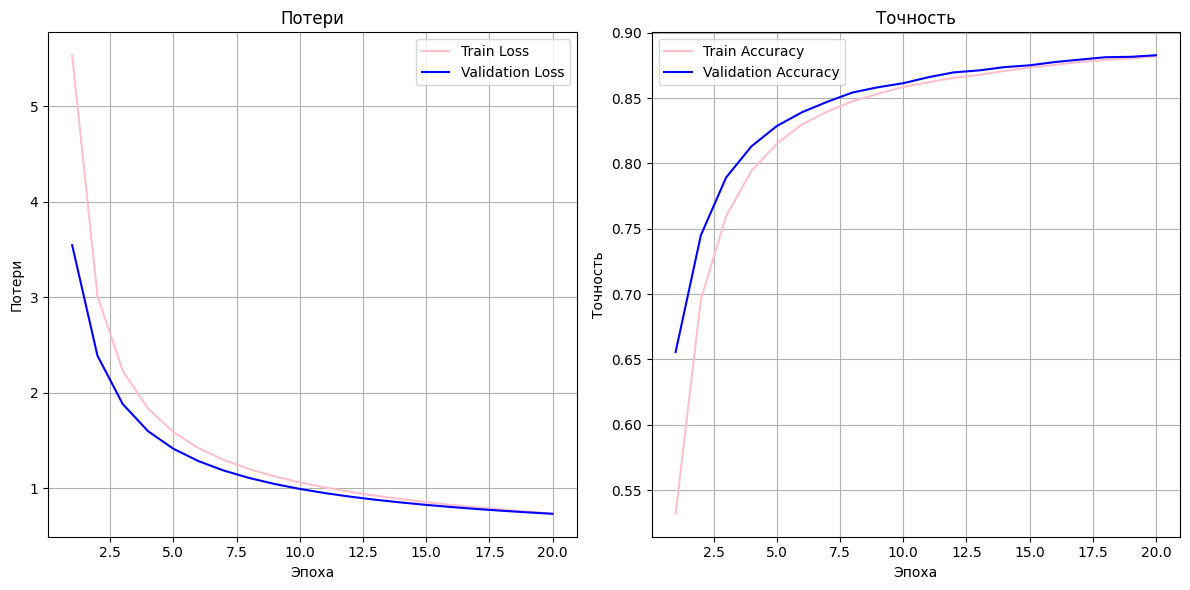

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="pink")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="pink")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
class DenseNetwork(nn.Module):
    def __init__(self, in_features=28**2, out_features=10, activ=None):
        super().__init__()
        if activ is None:
            activ = nn.ReLU()
        self.flat = nn.Flatten()
        self.activ = activ
        self.linear_1 = nn.Linear(in_features, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.flat(x)
        x = self.activ(self.linear_1(x))
        x = self.activ(self.linear_2(x))
        x = self.linear_3(x)
        return x

Можно ли было в данном случае не писать класс, а просто применить Sequential? Да, но оформив модель через класс мы имеем возможность потом модифицировать поведение уже обученной модели, обратившись к её полям.

In [19]:
model = DenseNetwork(in_features=28**2, out_features=10, activ=nn.ReLU()).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20
train_history, val_history = learning_loop(
    train_dataloader, valid_dataloader, model, criterion, optimizer, epochs=epochs
)

train_losses, train_accuracies = zip(*train_history)
val_losses, val_accuracies = zip(*val_history)

epoch: 1; losses: 0.4430528439756141, 0.248421540413099; accuracy: 0.86865, 0.9222
epoch: 2; losses: 0.21873343254584493, 0.16897617579331692; accuracy: 0.93475, 0.9472
epoch: 3; losses: 0.15535296137526092, 0.1474552024656883; accuracy: 0.9529166666666666, 0.9535
epoch: 4; losses: 0.12093997518939059, 0.12951770979289226; accuracy: 0.9628, 0.9608
epoch: 5; losses: 0.09815919657609165, 0.11656739152643736; accuracy: 0.9701166666666666, 0.966
epoch: 6; losses: 0.08346735057569961, 0.10850357411236243; accuracy: 0.9743, 0.9669
epoch: 7; losses: 0.07163115986176073, 0.09989863600916395; accuracy: 0.9782, 0.9709
epoch: 8; losses: 0.062773175723255, 0.0933296997741136; accuracy: 0.98085, 0.9738
epoch: 9; losses: 0.05598369622970425, 0.09599715787587655; accuracy: 0.9827, 0.9733
epoch: 10; losses: 0.04992816581734335, 0.10966164466119636; accuracy: 0.9839833333333333, 0.9694
epoch: 11; losses: 0.04810986818839063, 0.11415381778305679; accuracy: 0.9847166666666667, 0.9667
epoch: 12; losses: 0

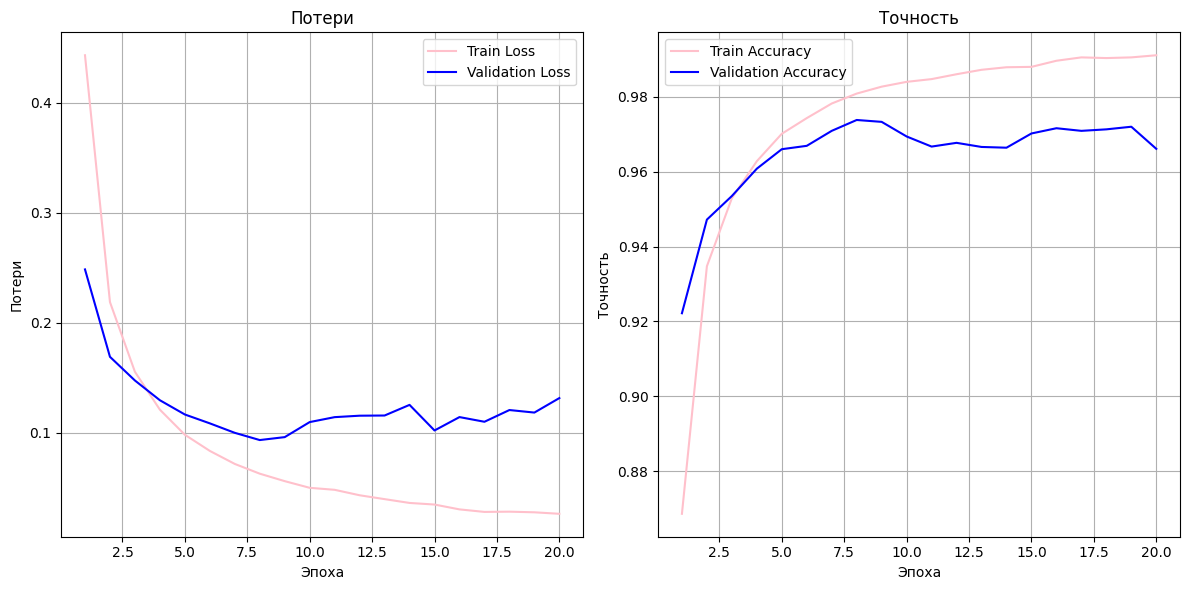

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="pink")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="pink")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Создайте новые модели с другими функциями активации. Попробуйте: гиперболический тангенс, сигмоиду, ELU, LeakyReLU. Все их можно найти в torch.nn.functional. Обучите их, постройте и сравните между собой графики обучения.

In [21]:
def train_and_evaluate(activation_function, train_loader, val_loader, epochs=20):
    model = DenseNetwork(activ=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    train_history, val_history = learning_loop(
        train_loader, val_loader, model, criterion, optimizer, epochs=epochs
    )

    return train_history, val_history

activations = {
    "ReLU": F.relu,
    "Tanh": F.tanh,
    "Sigmoid": F.sigmoid,
    "ELU": F.elu,
    "LeakyReLU": F.leaky_relu
}

history = {}

for name, activ in activations.items():
    print(f"Training model with {name} activation function")
    train_history, val_history = train_and_evaluate(activ, train_dataloader, valid_dataloader)
    history[name] = (train_history, val_history)



Training model with ReLU activation function
epoch: 1; losses: 0.4690554257172511, 0.25528298718029563; accuracy: 0.8634, 0.9234
epoch: 2; losses: 0.23347473585370507, 0.17853844959783968; accuracy: 0.9297333333333333, 0.9431
epoch: 3; losses: 0.1641413585535054, 0.157458407052828; accuracy: 0.9501166666666667, 0.9518
epoch: 4; losses: 0.12835576732569476, 0.1415019477422856; accuracy: 0.9609, 0.9565
epoch: 5; losses: 0.10550560986102898, 0.1282674255670355; accuracy: 0.9680333333333333, 0.9608
epoch: 6; losses: 0.08919018908922098, 0.11793704948511824; accuracy: 0.9729666666666666, 0.9645
epoch: 7; losses: 0.07630454213010954, 0.11453489727440844; accuracy: 0.9768166666666667, 0.9645
epoch: 8; losses: 0.0664974418488631, 0.1133511495987201; accuracy: 0.9799666666666667, 0.9666
epoch: 9; losses: 0.06082195415298568, 0.11060669758914132; accuracy: 0.9811166666666666, 0.9672
epoch: 10; losses: 0.054872110130579105, 0.1181394978926688; accuracy: 0.9827666666666667, 0.9648
epoch: 11; losse

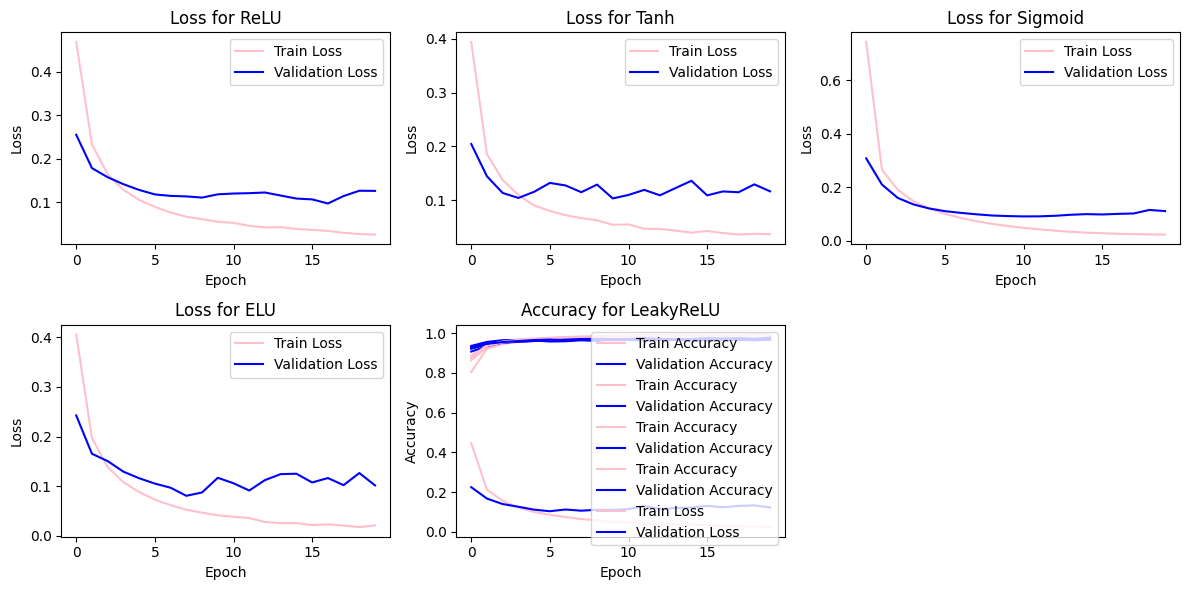

In [25]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

for i, (name, (train_h, val_h)) in enumerate(history.items()):
    train_losses, train_accuracies = zip(*train_h)
    val_losses, val_accuracies = zip(*val_h)

    plt.subplot(2, 3, i + 1)  # Создаем подграфики
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss", color="pink")
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", color="blue")
    plt.title(f'Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, len(history)) # Создаем подграфики для accuracy
    plt.plot(range(len(train_accuracies)), train_accuracies, label="Train Accuracy", color="pink")
    plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="blue")
    plt.title(f'Accuracy for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')



plt.tight_layout()
plt.show()


Теперь вам предстоит написать свою первую сверточную нейросеть. Превая версия архитектура LeNet была предложена еще аж в 1998 году. Вам предлагается реализовать её в таком виде:


*   Свертки 3x3 переход из 1 карты в 6 + ReLU
*   MaxPooling 2x2
*   Свертки 3x3 переход из 6 карт в 16 + ReLU
*   MaxPooling 2x2
*   Выпрямление (flatten)
*   Полносвязный слой, 120 нейронов + ReLU
*   Полносвязный слой, 84 нейрона + ReLU
*   Классификационный слой, 10 нейронов

Свертки можно брать из nn.Conv2d, пулинг - из nn.MaxPool2d, их сигнатуры можно загуглить.





In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Первый свертка: 1 входной канал, 6 выходных каналов, размер ядра 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        # Второй свертка: 6 входных каналов, 16 выходных каналов, размер ядра 3x3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)

        # Полносвязные слои
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 16 выходных карт после второго свертки и пулинга
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 классов для классификации

    def forward(self, x):
        # Прямой проход через слои
        x = F.relu(self.conv1(x))  # Свертка + ReLU
        x = F.max_pool2d(x, kernel_size=2)  # MaxPooling

        x = F.relu(self.conv2(x))  # Свертка + ReLU
        x = F.max_pool2d(x, kernel_size=2)  # MaxPooling

        x = x.view(x.size(0), -1)  # Выпрямление (flatten)

        x = F.relu(self.fc1(x))  # Полносвязный слой + ReLU
        x = F.relu(self.fc2(x))  # Полносвязный слой + ReLU
        x = self.fc3(x)  # Классификационный слой

        return x

In [44]:
def learning_loop(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs):
    train_history, val_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_history.append((train_loss / len(train_dataloader), train_accuracy))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        val_history.append((val_loss / len(valid_dataloader), val_accuracy))

    return train_history, val_history

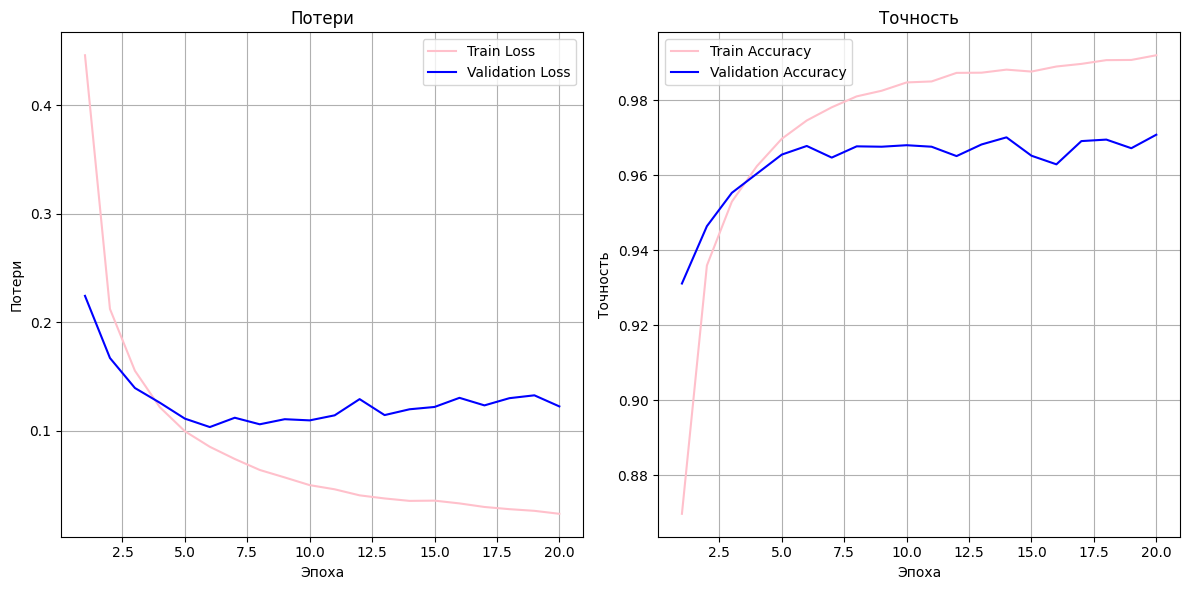

In [46]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="pink")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color="pink")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color="blue")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Проанализируйте полученные результаты, постройте сравнительные графики для точности на валидационной выборке у трех разных моделей. В качестве задачи со звездочкой, можете попробовать поиграть со своей архитектурой сверточной нейронной сети (можно варьировать количество слоев, количество нейронов в них, добавлять в свертки padding, а в полносвязную часть skip-connections).